In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import keras
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from quantum_base import Net as Net_orig
from quantum_base_kerr import Net as Net_kerr
from data import generate_synthetic_dataset_easy
from Plotting.Plot import BasicPlot, MultiPlot
tf.compat.v1.enable_eager_execution()
import pandas as pd
import seaborn as sns
from CalculateFisherInformation import Calculate_Fisher_Information_Matrix
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 0.5

tf.random.set_seed(None)

%load_ext autoreload
%autoreload 2

# Second Method
Taken from https://github.com/amyami187/effective_dimension/blob/v1.0.0/effective_dimension/classical_nn.py

In [2]:
@tf.function
def get_grads(inputs, model):
    with tf.GradientTape() as t:
        t.watch(model.trainable_variables)
        outputs = model(inputs)
    return t.jacobian(outputs, model.trainable_variables)


def calc_total_params(inputs, model):
    outputs = model(inputs)
    total_params = [inputs.shape[-1]] + [l.output_shape[1] for l in model.layers]
    total_params = sum([total_params[i]*total_params[i+1] for i in range(len(total_params)-1)]) + (sum(total_params[1:]) if model.layers[1].use_bias else 0)
    return total_params



def get_fisher(grads=np.array([[[]]]), total_params=0, n_classes=0, n_iter=10):
    fishers = np.zeros([len(grads), total_params, total_params])
    for i in range(len(grads)):
        grad = grads[i]
        temp_sum = np.zeros([n_classes, total_params, total_params])
        for j in range(n_classes):
            temp_sum[j] += np.outer(grad[j], np.transpose(grad[j]))
        fishers[i] = np.sum(temp_sum, axis=0)
    return fishers

def process_fishers(fishers, total_params, n_iter, num_datapoints, param_vol=1):
    fisher_trace = np.trace(np.mean(fishers, axis=0))
    fishers = np.mean(np.reshape(fishers, [n_iter, int(num_datapoints*0.7), total_params, total_params]), axis=0)
    fhat = fishers * total_params * param_vol / fisher_trace
    return fhat, fisher_trace

def get_all_grads(inputs, models):
    total_params = calc_total_params(inputs[0], models[0])
    grads = np.zeros([len(inputs), len(inputs[0]), n_classes, total_params]) 
    for count,(i,m) in enumerate(zip(inputs, models)):
        outputs = m(i)
        grad = get_grads(i, model)
        grad = tf.concat([tf.reshape(g, [g.shape[0], g.shape[1], tf.reduce_prod(g.shape[2:])]) for g in grad], axis=-1).numpy()
        grads[count] = grad
    grads = grads.reshape([len(inputs) * len(inputs[0]), n_classes, total_params])
    return grads

    

n_features = 8
n_classes = 4
n_layers = 1
num_datapoints = 100
n_iter = 100

(x_train, y_train), (x_test, y_test) = generate_synthetic_dataset_easy(num_datapoints=num_datapoints, n_features=n_features, n_classes=n_classes)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

model_func = lambda : Net(
    network_type='classical',
    n_layers=1,
    num_qumodes=2,
    cutoff=2,
    max_initial_weight=0.1

)

model = model_func()
model(x_train[0:1])
display(model.summary())
models = [model_func() for _ in range(n_iter)]

input_shape = x_train.shape[0:]
inputs = np.random.uniform(-1, 1, size=[n_iter] + list(x_train.shape))
total_params = calc_total_params(inputs[0], model)
grads = get_all_grads(inputs, models)
print(grads.shape)
fishers = get_fisher(grads=grads, total_params=total_params, n_classes=n_classes, n_iter=n_iter)
fhat, fisher_trace = process_fishers(fishers, total_params, n_iter=n_iter, num_datapoints=num_datapoints)

print(f'Inputs: {inputs[0].shape}')
print(f'Grad: {grads.shape}')
print(f'Fisher: {fishers.shape}')
print(f'Fhat: {fhat.shape}')

eigvals = np.linalg.eigvals(fhat).real
print(f'Mean: {np.mean(eigvals)}, Max: {np.max(eigvals)}, Min: {np.min(eigvals)}, STD: {np.std(eigvals)}')
print(f'Eigvals: {eigvals.shape}')
eigvals = eigvals.flatten()
sns.boxplot(eigvals)
plt.show()
sns.boxplot(eigvals[eigvals < 1])

print(len(eigvals[eigvals < 1])/len(eigvals))

2023-08-29 18:20:01.541494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 18:20:01.541883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:
2023-08-29 18:20:01.542029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:
2023-08-29 18:20:01.542181: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH:

Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 4)                    36        
                                                                 
 sequential_1 (Sequential)   (1, 4)                    20        
                                                                 
 sequential_2 (Sequential)   (1, 4)                    20        
                                                                 
Total params: 76
Trainable params: 56
Non-trainable params: 20
_________________________________________________________________


None

AttributeError: 'Sequential' object has no attribute 'use_bias'

In [2]:
model_func = lambda : Net_kerr(
    network_type='quantum',
    n_layers=3,
    num_qumodes=2,
    cutoff=2,
    max_initial_weight=0.1
)

# model_func = lambda : keras.models.Sequential([
#         keras.layers.Dense(4, activation='relu', kernel_initializer='random_uniform'),
#         keras.layers.Dense(4, activation='relu', kernel_initializer='random_uniform'),
#         keras.layers.Dense(2, activation='softmax', kernel_initializer='random_uniform')
#     ])

x_train = np.random.uniform(-1, 1, size=[20, 2])

model = model_func()
print(model(x_train[0:1]))

display(model.summary())
fisher_obj = Calculate_Fisher_Information_Matrix(
    model_func=model_func,
    x_train=x_train,
    n_iter=5,
)

fhat = fisher_obj.get_fhat()
fhat_eigvals = fisher_obj.calc_eigvals().flatten()





2023-08-29 18:48:35.690419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-29 18:48:35.690916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:
2023-08-29 18:48:35.691036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:
2023-08-29 18:48:35.691107: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH:

tf.Tensor([[0.25 0.25 0.25 0.25]], shape=(1, 4), dtype=float32)
Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 10)                   30        
                                                                 
 quantum_layer__multi_qunode  multiple                 54        
  (QuantumLayer_MultiQunode)                                     
                                                                 
 sequential_1 (Sequential)   (1, 4)                    12        
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


None

: 

1.0
Mean: 1.0000000000000004, Max: 36.24596114931165, Min: -1.3789116117387576e-15, STD: 4.67598942313236


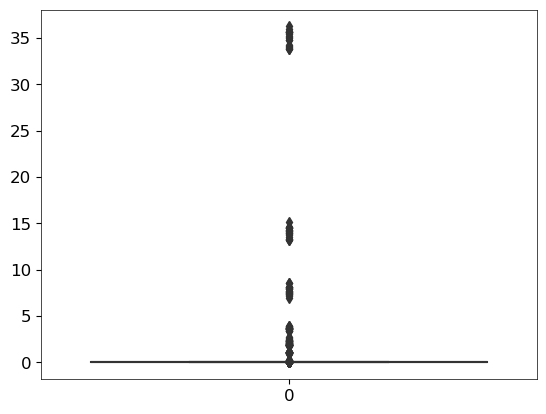

0.8962121212121212


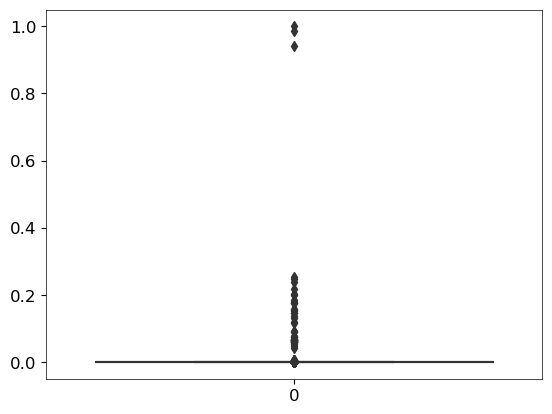

In [4]:
print(fisher_obj.param_vol)
print(f'Mean: {np.mean(fhat_eigvals)}, Max: {np.max(fhat_eigvals)}, Min: {np.min(fhat_eigvals)}, STD: {np.std(fhat_eigvals)}')
sns.boxplot(fhat_eigvals)
plt.show()
sns.boxplot(fhat_eigvals[fhat_eigvals < 1])
print(len(fhat_eigvals[fhat_eigvals < 1])/len(fhat_eigvals))